In [1]:
import awkward as awk
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
plt.style.use("../figures.mplstyle")
import numpy as np

In [2]:
filename = {"IceCube":"IceCube_DIS.parquet",
            "DUNE":"DUNE_DIS.parquet",
            "ATLAS":"ATLAS_DIS.parquet"}

Erange = {"IceCube":(1e0,2e6),
          "DUNE":(1e0,2e6),
          "ATLAS":(1e-1,2e5)}

Crange = {"IceCube":(-1,1),
          "DUNE":(-1,1),
          "ATLAS":(0.9,1)}

In [3]:
# Kinematic distributions

def plot_kinematics(data,k,nbins=30,savestr=None):
    
    _Erange = Erange[k]
    _Crange = Crange[k]
    
    fig,ax = plt.subplots(2,1,figsize=(8,12))
    
    twin0 = ax[0].twinx()
    twin1 = ax[1].twinx()
    
    for _ax in [twin0,twin1,ax[0],ax[1]]:
        _ax.set_prop_cycle(color=['red', 'green', 'blue'])
    
    
    # initial nu
    nu_flag = data["primary_type"]=="ParticleType.NuMu"
    nu_momenta = np.squeeze(data["primary_momentum"][nu_flag])

    # muon
    muon_flag = data["secondary_types"]=='ParticleType.MuMinus'
    muon_momenta = data["secondary_momenta"][muon_flag]
    # mask out entries that are not muon
    muon_momenta = awk.mask(muon_momenta, awk.num(muon_momenta,axis=2)>0)
    muon_momenta = np.squeeze(muon_momenta[~awk.is_none(muon_momenta,axis=1)])

    # hadron
    hadron_flag = data["secondary_types"]=='ParticleType.Hadrons'
    hadron_momenta = data["secondary_momenta"][hadron_flag]
    # mask out entries that are not hadron
    hadron_momenta = awk.mask(hadron_momenta, awk.num(hadron_momenta,axis=2)>0)
    hadron_momenta = np.squeeze(hadron_momenta[~awk.is_none(hadron_momenta,axis=1)])

    kwargs = {"bins":np.logspace(np.log10(_Erange[0]),np.log10(_Erange[1]),nbins),
              "weights":data["event_weight"],
              "histtype":"step"}

    # Energy
    n,_,_ = ax[0].hist(nu_momenta[:,0],**kwargs,label=r"Initial $\nu$")
    ax[0].hist(muon_momenta[:,0],**kwargs,label=r"Outgoing $\mu$")
    ax[0].hist(hadron_momenta[:,0],**kwargs,label=r"Outgoing Hadrons")
    
    kwargs["weights"] = None
    kwargs["ls"] = "--"
    
    n,_,_ = twin0.hist(nu_momenta[:,0],**kwargs)
    twin0.hist(muon_momenta[:,0],**kwargs)
    twin0.hist(hadron_momenta[:,0],**kwargs)
    
    # Angle
    def CosTheta(momenta):
        return momenta[:,3]/np.linalg.norm(momenta[:,1:],axis=-1)
    
    kwargs["bins"] = np.linspace(_Crange[0],_Crange[1],nbins)
    kwargs["weights"] = data["event_weight"]
    kwargs["ls"] = None
    
    m,_,_ = ax[1].hist(CosTheta(nu_momenta),**kwargs,label=r"Initial $\nu$")
    ax[1].hist(CosTheta(muon_momenta),**kwargs,label=r"Outgoing $\mu$")
    ax[1].hist(CosTheta(hadron_momenta),**kwargs,label=r"Outgoing Hadrons")
    
    kwargs["weights"] = None
    kwargs["ls"] = "--"
    
    m,_,_ = twin1.hist(CosTheta(nu_momenta),**kwargs,label=r"Initial $\nu$")
    twin1.hist(CosTheta(muon_momenta),**kwargs,label=r"Outgoing $\mu$")
    twin1.hist(CosTheta(hadron_momenta),**kwargs,label=r"Outgoing Hadrons")
    
    ax[0].legend(loc="upper left")
    ax[0].loglog()
    twin0.loglog()
    ax[0].set_xlabel("Energy [GeV]")
    ax[0].set_ylabel("Physical Events / [Time]")
    twin0.set_ylabel("Generated Events")
    ax[0].set_xlim(*_Erange)
    
    ax[1].legend(loc="upper left" if k=="ATLAS" else "lower right")
    ax[1].semilogy()
    twin1.semilogy()
    ax[1].set_xlabel(r"$\cos \theta$")
    ax[1].set_ylabel("Physical Events / [Time]")
    twin1.set_ylabel("Generated Events")
    ax[1].set_xlim(*_Crange)
    twin1.set_ylim(1,2*max(m))
        
    if savestr is not None:
        plt.savefig(savestr+"_kinematics.pdf",dpi=100)
    plt.show()

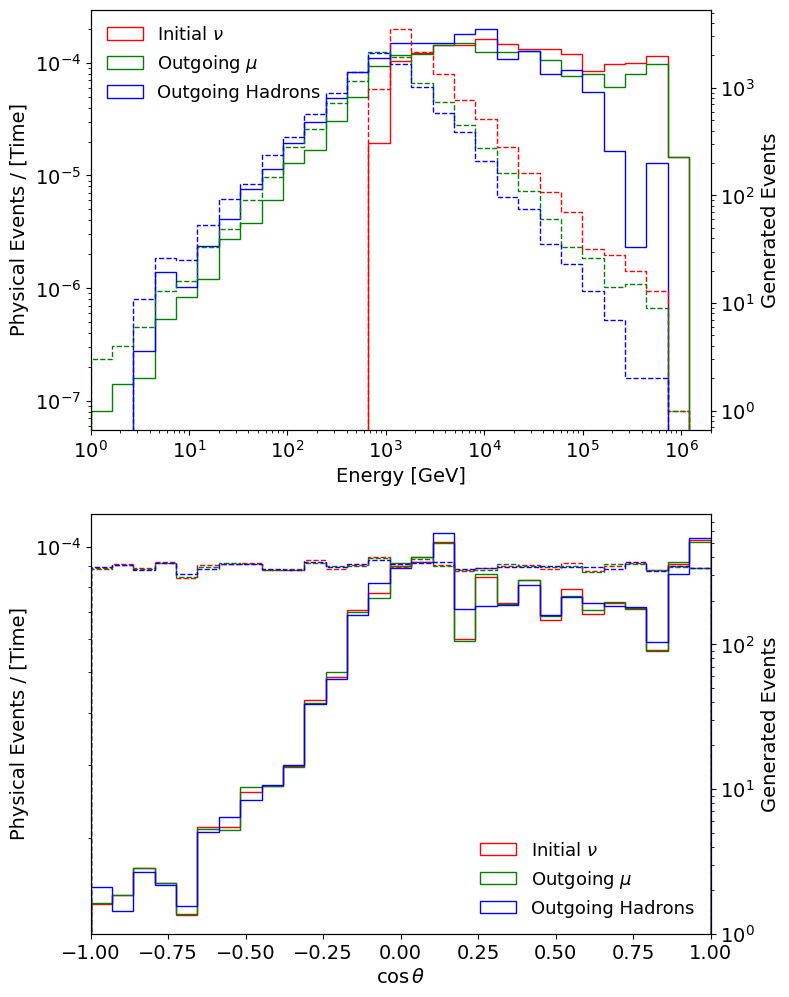

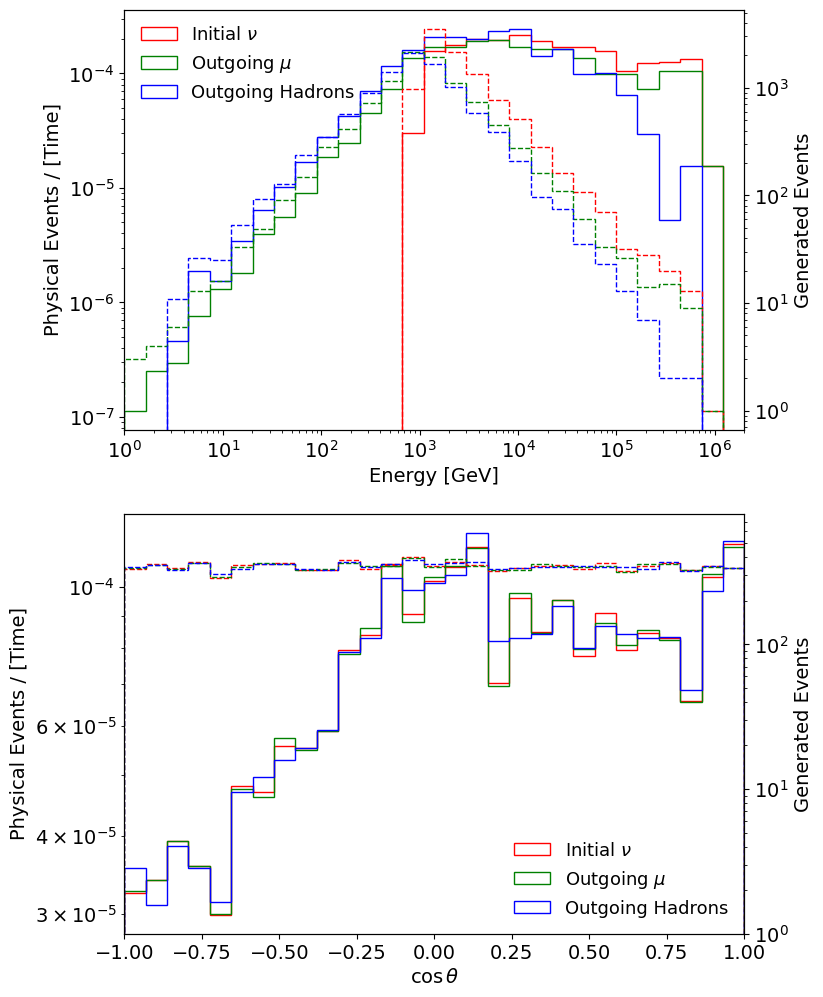

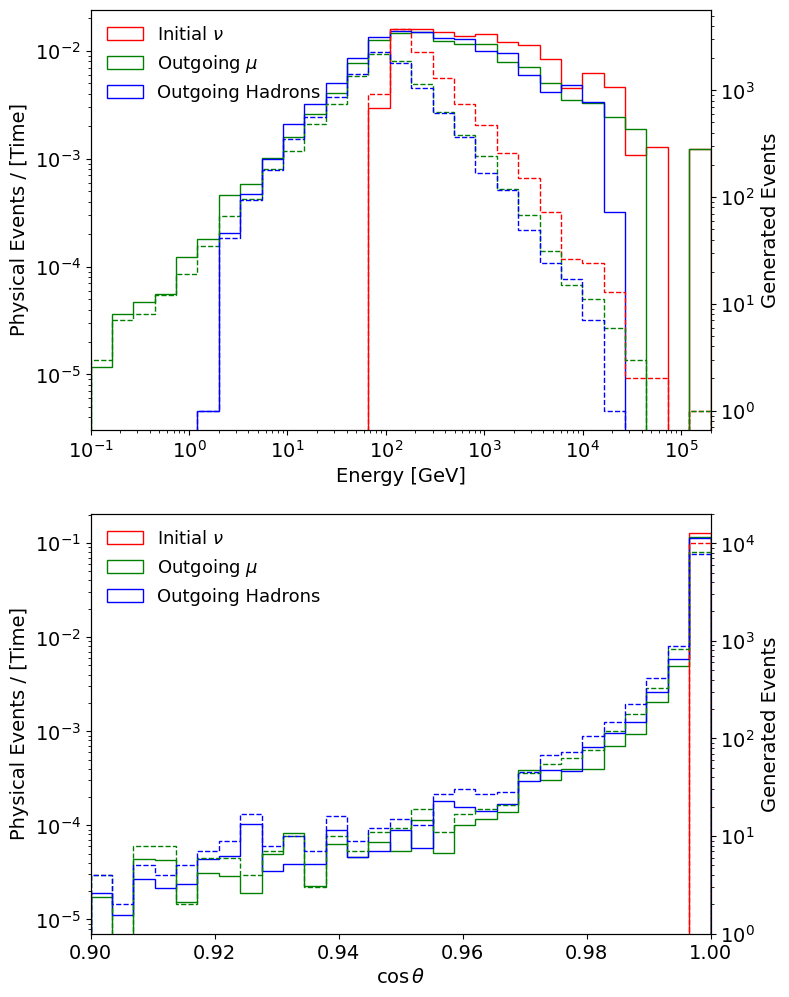

In [4]:
for k in filename.keys():
    data = awk.from_parquet("output/"+filename[k])
    plot_kinematics(data,k,savestr="figures/%s"%k)